# Unilever decoder RNN model

## Model

<img src="./images/architecture2.png">

In [1]:
import pandas as pd

In [2]:
# ---- Imports -----
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
# import torch
# import torch.nn as nn
# from torch import optim
# import torch.nn.functional as F



# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print('device:', device)

In [3]:
from pickle import load
from numpy import array
# import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, GRU
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Reading a text file for test purpouses

In [4]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='ansi')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [5]:
# function that splits a loaded document into sentences
def to_lines(doc):
    exclude = set(string.punctuation)
    doc2 = ''.join(ch for ch in doc if ch not in exclude)
    lines = doc2.strip().split('\n')
    return lines

In [6]:
# load dataset
filename = 'sample_text.txt'
doc = load_doc(filename)
lines = to_lines(doc)

In [ ]:
lines[0:10]

## Preparing data for the decoder
Get commentaries and dictionary from file

In [8]:
#Import dataframes from pickle file (saved previously)
from helper_save_load import load_from_pickle
import pandas
dfc, vocab, word_to_ix, ix_to_word = load_from_pickle("commentaries.pickle")
# display(dfc.head(2))
# print('index of word lcl:', word_to_ix['lcl'])
# print('word at index 0:', ix_to_word[0])

In [ ]:
dfc['Comment_w'].replace('[NOC]', '[SOS] [EOS]', inplace=True)   #replace NoComment with StartOfSentence + EndOfSentence
commentaries = dfc['Comment_w']
commentaries[0:5]

In [ ]:
# commentaries = lines
# commentaries[0:5]

### Tokenizing words (RNN2 inputs and outputs)

In [12]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [13]:
# prepare tokenizer for commentaries
tokenizer = create_tokenizer(commentaries)
# tokenizer.word_index

In [14]:
#Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
#Calculate maximum length of commentaries
com_length = max_length(commentaries)

print('Vocabulary size (vocab_size):', vocab_size)
print('Max length of commentary (com_length):', com_length)
print('Number of commentaries :', len(commentaries))

Vocabulary size (vocab_size): 678
Max length of commentary (com_length): 127
Number of commentaries : 1093


In [15]:
#Filter only non empty commentaries
commentaries = [c for c in commentaries if c != '[SOS] [EOS]']

In [16]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

#Tokenizing all comments



trainX = encode_sequences(tokenizer, com_length, commentaries)
print('trainX=\n', trainX)

#Shifting tokenized words by 1 to predict next word in RNN2
trainY = np.zeros((len(commentaries), com_length), dtype='int')
trainY[:,0:com_length-2] = trainX[:,1:com_length-1]
# trainY = trainX
print('\ntrainY=\n', trainY)

trainX=
 [[  1  18  19 ...   0   0   0]
 [  1  18  19 ...   0   0   0]
 [  1 130  68 ...   0   0   0]
 ...
 [  1   4  38 ...   0   0   0]
 [  1   3  71 ...   0   0   0]
 [  1   3  71 ...   0   0   0]]

trainY=
 [[ 18  19 388 ...   0   0   0]
 [ 18  19   8 ...   0   0   0]
 [130  68   2 ...   0   0   0]
 ...
 [  4  38  22 ...   0   0   0]
 [  3  71   6 ...   0   0   0]
 [  3  71   6 ...   0   0   0]]


### One-hot encoding RNN2 outputs

In [17]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

trainY = encode_output(trainY, vocab_size)
# trainY

In [18]:
#One-hot encode inputs in trainX_oh 
# trainX_oh = encode_output(trainX, vocab_size)
# trainX_oh

## 2. Decoder (RNN2)

Receives the variance vector that is concatenated with the embedding vector of the word, then is trained to predict the next word using the current word from the commentary of month i related to brand k. 

**It makes senses also to classify the commentaries in classes, such as: over delivery, driven by territory, orders phased, ...**

<img src="./images/decoder-arch.png">

encoder_input_data = (comment_num, variance pos, variance value)  => dimension (comment len, variance vector len, 1)

decoder_input_data = (comment num, word pos, word one-hot encoded vector) => (comments number, comment len, vocab_size )

decoder_target_data = (comment num, word pos, word one-hot encoded vector) - words are shifted of 1

**RNN2** :
- **samples**: number of comments: `num_comments` 
- **time steps**: max length of a commentary: `com_length`
- **Features**: token of each time step: `1`

## Model without encoder +embedding (without variance inputs)

In [19]:
#Embedding size
embed_size = 100
# Preparing parameters
hidden_size = 300
# Number of words in vocabulary
src_vocab = vocab_size
tar_vocab = src_vocab
# Max length of input/ouput sentence
src_timesteps = com_length #max(len(line.split()) for line in dfc['Comment_w'])
tar_timesteps = src_timesteps
# Length of variance vector
# varv_length = len(empty_df.columns)
# Number of commentaries
num_comments = len(commentaries)

#Overview of the parameters calculated from dataset
print('Embedding size: embed_size =', embed_size)
print('Size of LSTM: hidden_size =', hidden_size)
print('Commentaries vocabulary length: src_vocab =', src_vocab)
print('Commentaries length (output): src_timesteps =', src_timesteps)
# print('Variance vector length: varv_length =', varv_length)
print('Number of commentaries: num_comments =', num_comments)

Embedding size: embed_size = 100
Size of LSTM: hidden_size = 300
Commentaries vocabulary length: src_vocab = 678
Commentaries length (output): src_timesteps = 127
Number of commentaries: num_comments = 275


In [20]:
##################  Second version without variance vector, only training on commentaries with RNN2 #################
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))    #src_timesteps #we feed the decoder with tokenized word

word_Embedding = Embedding(src_vocab, embed_size,  mask_zero=True)  #input_length=src_timesteps,
embded_out = word_Embedding(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(hidden_size, return_sequences=True)      #, return_sequences=True, return_state=True)
decoder_outputs = decoder_lstm(embded_out)  #.reshape(-1,embed_size)     #(decoder_inputs)

decoder_dense = Dense(src_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model(decoder_inputs, decoder_outputs)

# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy')      #rmsprop
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         67800     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 300)         481200    
_________________________________________________________________
dense_1 (Dense)              (None, None, 678)         204078    
Total params: 753,078
Trainable params: 753,078
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
################## Training model without variance #################################
batch_size = 20
epochs = 100

filename = 'unilever_WVOH.h5'
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=1)
#validation_split=0.2)

Epoch 1/100
275/275 [==============================] - 11s 40ms/step - loss: 0.3323

Epoch 00001: loss improved from inf to 0.33229, saving model to unilever_WVOH.h5
Epoch 2/100
275/275 [==============================] - 12s 43ms/step - loss: 0.3299

Epoch 00002: loss improved from 0.33229 to 0.32993, saving model to unilever_WVOH.h5
Epoch 3/100
275/275 [==============================] - 12s 44ms/step - loss: 0.3277

Epoch 00003: loss improved from 0.32993 to 0.32774, saving model to unilever_WVOH.h5
Epoch 4/100
275/275 [==============================] - 12s 43ms/step - loss: 0.3285

Epoch 00004: loss did not improve from 0.32774
Epoch 5/100
275/275 [==============================] - 11s 39ms/step - loss: 0.3246

Epoch 00005: loss improved from 0.32774 to 0.32460, saving model to unilever_WVOH.h5
Epoch 6/100
275/275 [==============================] - 12s 43ms/step - loss: 0.3248

Epoch 00006: loss did not improve from 0.32460
Epoch 7/100
275/275 [==============================] - 12s 4

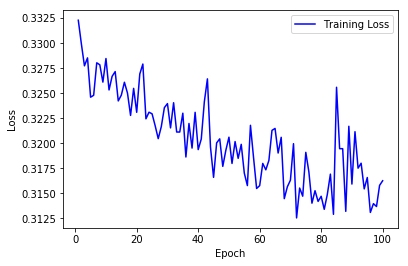

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
# test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b')
# plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [26]:
############## Sampling model without encoder + Embedding #################
decoder_outputs = word_Embedding(decoder_inputs)
decoder_outputs = decoder_lstm(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(decoder_inputs, decoder_outputs)

In [27]:
reverse_input_word_index = dict((i+1, word) for i, word in enumerate(tokenizer.word_index))
reverse_input_word_index[0] = ''

In [ ]:
######### Sampling with model without encoder + Embedding ########
import sys

for i in range(1,50):
    c = random.randint(0,len(commentaries)-1)
    comment = commentaries[c].split()
    if comment[1] == '[EOS]': continue

    print('\nc=',c)
    print('Original comment: ', commentaries[c])    

    # Generate empty target sequence.
    target_seq = np.zeros((1, 1))  
    # Populate the first character of target sequence with the start character.
#     target_seq[0, 0] = tokenizer.word_index['[sos]']       

    seed = comment[0].lower()
    target_seq[0, 0] = tokenizer.word_index[seed]
    print('seed word:', seed)
    sys.stdout.write(seed)
    sys.stdout.write('-----')
    decoded_sentence = []
    decoded_sentence.append (seed)

#     target_seq = trainXr[c:c+1]
#     print('target_seq =', target_seq)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    i = 0


    while not stop_condition:
        output_tokens = decoder_model.predict(target_seq)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_word = reverse_input_word_index[sampled_token_index]
        decoded_sentence.append (sampled_word)
        
#         print(reverse_input_word_index[target_seq[0, 0]],' -->',sampled_word)
        
        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_sentence) > src_timesteps):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        if i<len(comment):
            target_seq[0, 0] = tokenizer.word_index[comment[i].lower()]
            i = i + 1
        else:
            target_seq[0, 0] = sampled_token_index
            
#         target_seq[0, 0] = sampled_token_index

        
    print('Result =', ' '.join(decoded_sentence))


In [81]:
decoder = DecoderRNN(300, 1)
print(decoder)

DecoderRNN(
  (embedding): Embedding(1, 300)
  (gru): GRU(300, 300)
  (out): Linear(in_features=300, out_features=1, bias=True)
  (softmax): LogSoftmax()
)


## Global Architecture 

In [90]:
#define components sizes
CONTEXT_SIZE_1 = 300
CONTEXT_SIZE_2 = 300
EMBEDDING_DIM = 30


encoder = EncoderRNN(VAR_MONTH_DATA_SIZE, CONTEXT_SIZE_1)
decoder = DecoderRNN(CONTEXT_SIZE_2, 1)

learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()



In [91]:
#iteration here
encoder_hidden = encoder.initHidden()
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()


In [ ]:
#Training, you can re-run this function as much time as needed to train more
for epoch in range(60):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print('epoch %d : Total loss=%.3f' % (epoch, total_loss))
#print(losses)  # The loss decreased every iteration over the training data!

In [ ]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #Embedding matrix: each line is the embedding of one word
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #Parameter matrix embedding and hidden layer
        self.linear2 = nn.Linear(128, vocab_size)  #Parameter matrix between hidden layer and output

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  #get embedding from Embedding matrix
        out = F.relu(self.linear1(embeds))  #
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)

optimizer = optim.SGD(model.parameters(), lr=0.01)   #before 0.001

In [ ]:
#Training, you can re-run this function as much time as needed to train more
for epoch in range(60):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print('epoch %d : Total loss=%.3f' % (epoch, total_loss))
#print(losses)  # The loss decreased every iteration over the training data!

In [75]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Train and evaluate

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [2]:
line='this is a paragraph with<[1> in between</[1> and then there are cases ... where the<[99> number ranges from 1-100</[99>. and there are many other lines in the txt files with<[3> such tags </[3>'
import re
line = re.sub(r"</?\[\d+>", "", line)
line

'this is a paragraph with in between and then there are cases ... where the number ranges from 1-100. and there are many other lines in the txt files with such tags '

In [ ]:
import re
comment = 'baselines driven by improving pos l4 +3%'
aa = r"[0-9]+(\.[0-9]+)?\%"
comment = re.sub(aa, "[%]", comment)
comment = re.sub(r"\-\$[0-9].[0-9][0-9]M\b", "[-]", comment)
comment

In [ ]:
"/(^|\W)$[0-9]+(\.[0-9][0-9])?\b/"

## Updated version of Keras

In [135]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

num_encoder_tokens = 20
latent_dim = 200
encoder_inputs = 1

num_decoder_tokens = 30
decoder_outputs = 150


# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 20)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 30)     0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 200), (None, 176800      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 200),  184800      input_6[0][0]                    
                                                                 lstm_5[0][1]                     
          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 100)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200), (None, 240800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 200),  200800      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          